In [12]:
#그동안의 성능 지표를 한눈에 비교하기 위한 파일입니다.
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from tqdm import tqdm
import pandas as pd
from IPython.display import display, HTML

In [13]:
class args:
    DATA_PATH = "./data/inference"

In [14]:
#폴더 경로로부터 모델 예측 결과들만 가져옵니다.
def load_json_files_from_folder(folder_path):
    json_files = [f for f in os.listdir(folder_path) if (f.endswith('.json') and (not "Result" in f) ) ]
    json_data = {}
    
    for json_file in json_files:
        with open(os.path.join(folder_path, json_file), 'r', encoding='utf-8') as f:
            json_data[json_file] = json.load(f)
    
    return json_data

json_data_dict = load_json_files_from_folder(args.DATA_PATH)

In [15]:
#시각화 할 모델 목록입니다
print(json_data_dict.keys())

dict_keys(['SPLADE_Baseline.json', 'DPR_Baseline.json', 'BM25_Baseline.json'])


In [16]:
#사용할 평가지표는 Recall입니다.
def recall_at_k(relevant_docs, predicted_docs, k):
    relevant_set = set(relevant_docs)
    predicted_at_k = set(predicted_docs[:k])
    recall = len(relevant_set & predicted_at_k) / min(len(relevant_set),k)
    return recall

#예측 결과의 Recall@K 를 dict 형태로 return합니다
def return_average_recall(pred_result,
                          k_values = [1, 5, 10, 50, 100, 200, 500, 1000]):
    #Recall@K의 K값 리스트입니다.
    results = {k: [] for k in k_values}

    #각 query에 대해 recall값을 계산합니다.
    for qid, (relevant, predicted) in tqdm(pred_result.items()):
        for k in k_values:
            recall = recall_at_k(relevant, predicted, k)
            results[k].append(recall)

    #K 단위로 예측한 recall 값을 평균합니다.
    average_recall = {k: sum(recalls) / len(recalls) for k, recalls in results.items()}
    
    return average_recall

100%|██████████| 100/100 [00:00<00:00, 7471.68it/s]


100%|██████████| 100/100 [00:00<00:00, 7672.74it/s]


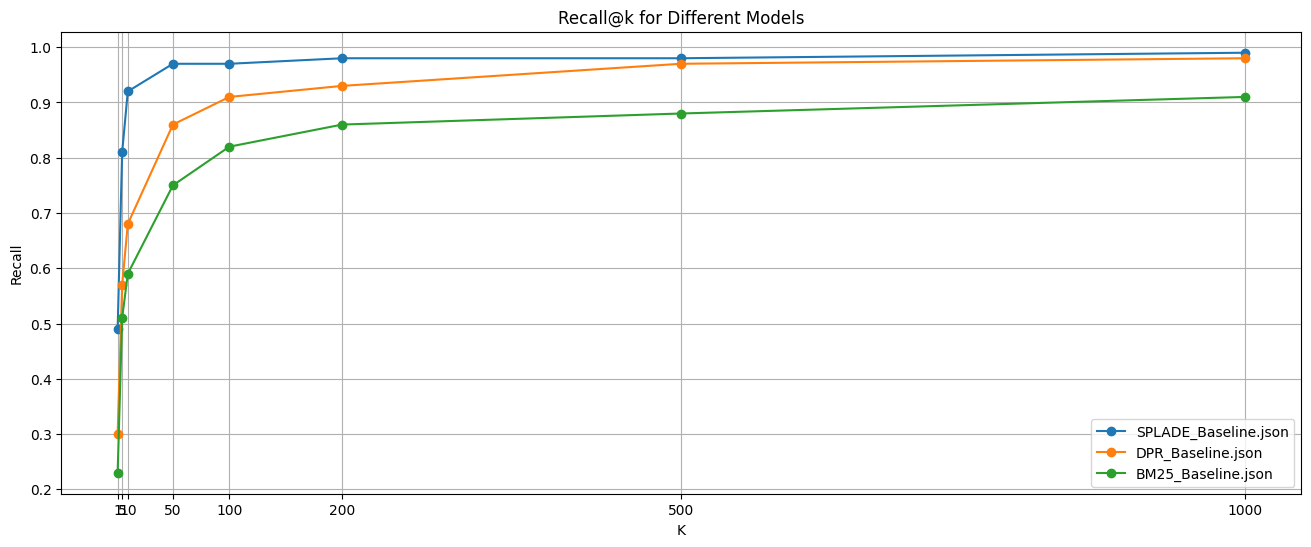

,SPLADE_Baseline.json,DPR_Baseline.json,BM25_Baseline.json
1,0.49,0.30,0.23
5,0.81,0.57,0.51
10,0.92,0.68,0.59
50,0.97,0.86,0.75
100,0.97,0.91,0.82
200,0.98,0.93,0.86
500,0.98,0.97,0.88
1000,0.99,0.98,0.91


In [17]:
#예측 결과를 한눈에 확인합니다
all_model_results = {}
for model_name, pred_result in json_data_dict.items():
    all_model_results[model_name] = return_average_recall(pred_result)

# Recall@K 값을 시각화
plt.figure(figsize=(16, 6))
for model_name, average_recall in all_model_results.items():
    plt.plot(list(average_recall.keys()), list(average_recall.values()), marker='o', linestyle='-', label=model_name)

plt.title('Recall@k for Different Models')
plt.xlabel('K')
plt.ylabel('Recall')
plt.xticks([1, 5, 10, 50, 100, 200, 500, 1000])
plt.legend()
plt.grid(True)
plt.show()

# Recall@K 값을 표로 정리
recall_df = pd.DataFrame(all_model_results)

display(HTML(recall_df.to_html()))